In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [63]:
# Load data
data = pd.read_csv('encoded_182625.csv')
print("Original Data Loaded:")
print(data.head())

Original Data Loaded:
   SeqOrder  sourceID  timediff     PTAB  BodyGroup_from  BodyGroup_to
0         0      10.0       0.0 -1182200               9             9
1         1       0.0      40.0 -1182200               9             9
2         2       4.0      45.0 -1181050               9             9
3         3       5.0      52.0 -1181050               9             9
4         4       5.0      68.0 -1181050               9             9


In [ ]:
# Print unique values to inspect for unexpected cases
print("Unique sourceID values:", data['sourceID'].unique())
print("Unique BodyGroup_from values:", data['BodyGroup_from'].unique())
print("Unique BodyGroup_to values:", data['BodyGroup_to'].unique())

In [64]:
# Ensure sourceID is string for mapping (if not already)
data['sourceID'] = data['sourceID'].astype(str)

# Provided encoding legends (as per your updated mapping)
sourceID_mapping = {
    'Not Vital': 0, 'MRI_CCS_11': 1, 'MRI_EXU_95': 2, 'MRI_FRR_18': 3,
    'MRI_FRR_257': 4, 'MRI_FRR_264': 5, 'MRI_FRR_3': 6, 'MRI_FRR_34': 7,
    'MRI_MPT_1005': 8, 'MRI_MSR_100': 9, 'MRI_MSR_104': 10, 'MRI_MSR_21': 11, 'MRI_MSR_34': 12
}

BODYGROUP_ENCODING = {
    'ABDOMEN': 1, 'ARM': 2, 'HEAD': 3, 'HEART': 4, 'HIP': 5,
    'KNEE': 6, 'LEG': 7, 'PELVIS': 8, 'SHOULDER': 9, 'SPINE': 10
}

# Encode categorical features using the mappings
data['sourceID_encoded'] = data['sourceID'].map(sourceID_mapping)
data['BodyGroup_from_encoded'] = data['BodyGroup_from'].map(BODYGROUP_ENCODING)
data['BodyGroup_to_encoded'] = data['BodyGroup_to'].map(BODYGROUP_ENCODING)

In [65]:
# Prepare input (X) and output (y) using encoded values
# Leaving numeric features (PTAB and SeqOrder) in their original scale.
X = data[['sourceID_encoded', 'PTAB', 'BodyGroup_from_encoded', 'BodyGroup_to_encoded', 'SeqOrder']].values
y = data['timediff'].values

# Create sequences for sequential processing
sequence_length = 10  # number of past steps used per prediction
X_seq, y_seq = [], []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i+sequence_length])
    # Here, summing the target values over the sequence window; change if needed.
    y_seq.append(np.sum(y[i:i+sequence_length]))

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

print("Shape of X_seq:", X_seq.shape)
print("Shape of y_seq:", y_seq.shape)

Shape of X_seq: (3790, 10, 5)
Shape of y_seq: (3790,)


In [66]:
# Split dataset
indices = np.arange(len(X_seq))
train_indices, temp_indices = train_test_split(indices, test_size=0.4, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.625, random_state=42)

X_train, y_train = X_seq[train_indices], y_seq[train_indices]
X_val, y_val = X_seq[val_indices], y_seq[val_indices]
X_test, y_test = X_seq[test_indices], y_seq[test_indices]

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (2274, 10, 5) (2274,)
Validation set shape: (568, 10, 5) (568,)
Test set shape: (948, 10, 5) (948,)


In [67]:
# Define custom loss function (if required)
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_true - y_pred))
    zero_penalty = K.sum(K.square(y_pred) * K.cast(K.equal(y_true, 0), K.floatx()))
    return mse_loss + zero_penalty

In [68]:
print("Any NaNs in features? ", np.isnan(X).sum())
print("Any NaNs in target? ", np.isnan(y).sum())


Any NaNs in features?  11400
Any NaNs in target?  0


In [60]:
# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # (sequence_length, num_features)
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# You can adjust the learning rate if needed; here we use 0.01 as in your original code.
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: nan - val_loss: nan
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - val_loss: nan
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - val_loss: nan
Epoch 13/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan

Test Loss: nan


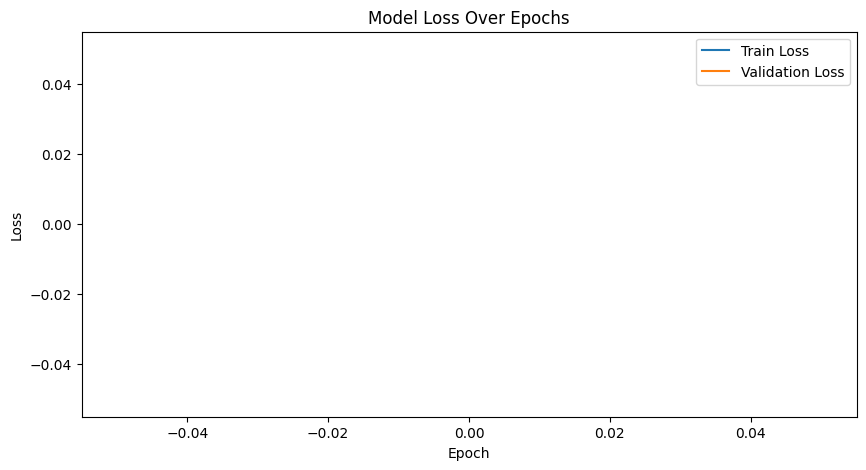

In [53]:
# Save the model (optional)
model.save('trained_model.h5')

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss}")

# Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Make predictions on test set
predictions = model.predict(X_test).flatten()

# Enforce a zero constraint on predictions where y_test is zero
predictions = np.where(y_test == 0, 0, predictions)

# Decode sourceIDs for readability using the inverse of the mapping:
inv_sourceID_mapping = {v: k for k, v in sourceID_mapping.items()}
decoded_sourceIDs = [inv_sourceID_mapping[int(data.loc[idx, 'sourceID_encoded'])] for idx in test_indices]

# Combine predictions with sourceIDs
results_df = pd.DataFrame({
    'SourceID': decoded_sourceIDs,
    'True Timediff': y_test,
    'Predicted Timediff': predictions
})

print(results_df.head())
results_df.to_csv('initial_throwaway_predictions_results.csv', index=False)
print("Results saved to initial_throwaway_predictions_results.csv")

# Plot true vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Values', marker='o')
plt.plot(predictions, label='Predicted Values', marker='x')
plt.title('True vs Predicted Timediff on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Timediff')
plt.legend()
plt.show()

# Evaluate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-Squared (R²): {r2}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


ValueError: cannot convert float NaN to integer

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense

In [19]:
# Load new dataset
df = pd.read_csv("predicSourceIDandBodyGroup_182625.csv")

print("New Data Loaded:")
print(df.head())

New Data Loaded:
   SeqOrder     sourceID BodyGroup_from BodyGroup_to
0         0  MRI_MSR_104        ABDOMEN      ABDOMEN
1         1   MRI_MSR_21        ABDOMEN      ABDOMEN
2         2  MRI_FRR_257        ABDOMEN      ABDOMEN
3         3  MRI_FRR_264        ABDOMEN      ABDOMEN
4         4    MRI_FRR_3        ABDOMEN      ABDOMEN


In [20]:
# Encoding legend
ENCODING_LEGEND = {
    'Not Vital': 0, 'MRI_CCS_11': 1, 'MRI_EXU_95': 2, 'MRI_FRR_18': 3, 'MRI_FRR_257': 4,
    'MRI_FRR_264': 5, 'MRI_FRR_3': 6, 'MRI_FRR_34': 7, 'MRI_MPT_1005': 8,
    'MRI_MSR_100': 9, 'MRI_MSR_104': 10, 'MRI_MSR_21': 11, 'MRI_MSR_34': 12
}

BODYGROUP_ENCODING = {
    'ABDOMEN': 1, 'ARM': 2, 'HEAD': 3, 'HEART': 4, 'HIP': 5,
    'KNEE': 6, 'LEG': 7, 'PELVIS': 8, 'SHOULDER': 9, 'SPINE': 10
}

In [21]:
# Encode sourceID and BodyGroup columns using predefined legends
df['sourceID_encoded'] = df['sourceID'].map(ENCODING_LEGEND)
df['BodyGroup_from_encoded'] = df['BodyGroup_from'].map(BODYGROUP_ENCODING)
df['BodyGroup_to_encoded'] = df['BodyGroup_to'].map(BODYGROUP_ENCODING)

# Ensure no NaNs exist (handle unknown sourceIDs or body groups)
df['sourceID_encoded'].fillna(-1, inplace=True)  # Use -1 for unknown values
df['BodyGroup_from_encoded'].fillna(0, inplace=True)
df['BodyGroup_to_encoded'].fillna(0, inplace=True)

# Convert to integer type after filling NaNs
df['sourceID_encoded'] = df['sourceID_encoded'].astype(int)
df['BodyGroup_from_encoded'] = df['BodyGroup_from_encoded'].astype(int)
df['BodyGroup_to_encoded'] = df['BodyGroup_to_encoded'].astype(int)

In [22]:
# Create the reset_flag column (AFTER encoding)
df['reset_flag'] = (df['sourceID_encoded'] == 10).astype(int)

# Ensure timediff is exactly 0 where reset_flag is 1
df.loc[df['reset_flag'] == 1, 'timediff'] = 0

# Add PTAB column if missing
if 'PTAB' not in df.columns:
    df['PTAB'] = 0  # Use default 0 (or replace with training data mean)

# Select the features for training
X = df[['sourceID_encoded', 'reset_flag']].values.astype(np.float32)  # Convert to float32
y = df['timediff'].values.astype(np.float32)  # Convert target to float32

# Reshape X for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Shape: (samples, 1 timestep, 2 features)

print("New X shape:", X.shape)  # Should be (samples, 1, 2)
print("New y shape:", y.shape)  # Should be (samples,)


New X shape: (1156, 1, 2)
New y shape: (1156,)


In [23]:
# Define LSTM Model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(1, 2)))  # 2 features
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(units=1, activation='linear'))  # Output layer

#Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20


c:\Users\lukis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: nan - val_loss: nan
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - val_loss: nan
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_loss: nan
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - val_lo

In [26]:
# Save the trained model
model.save("trained_lstm_model.h5")

# Load the trained model for inference
model = load_model("trained_lstm_model.h5")

# Predict timediff
df['Predicted_timediff'] = model.predict(X).flatten()
print("Predictions:", predictions[:20])  # See first few predictions


print("Unique y values:", np.unique(y))



37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predictions: [ 111.975784   15.802075   93.0547     15.061905   15.061905  299.48364
   15.061905   15.061905 1098.2986     15.061905  100.66293    15.061905
   15.061905  945.35645  1569.008      15.061905  931.49133    15.061905
   15.061905 1052.5536  ]
Unique y values: [ 0. nan]


In [27]:
# Apply cumulative sum but reset when sourceID == 10
cumulative_timediff = []
current_sum = 0

for i in range(len(df)):
    if df.iloc[i]['sourceID_encoded'] == 10:  # Reset when sourceID is MSR_104
        current_sum = 0
        cumulative_timediff.append(0)  # Ensure exact 0 for sourceID 10
    else:
        current_sum += df.iloc[i]['Predicted_timediff']
        cumulative_timediff.append(current_sum)

# Update the dataframe with final cumulative values
df['Cumulative_timediff'] = cumulative_timediff

# Save the updated dataset
df.to_csv('new_data_with_reset_predictions_flag_test.csv', index=False)
print("Updated dataset with resets saved!")

Updated dataset with resets saved!
